# Interval arithmetic 

The idea of interval arithmetic is to calculate with **sets** of real numbers, represented as intervals, $X = [a,b]$ (usually with closed end-points), and define an operation $\circ$ between two intervals $X = [a, b]$ and $Y = [c,d]$ as

$$X \circ Y := \{x \circ y: x \in X, y \in Y\},$$

i.e. the result should contain **all possible** results for any pair of values, one from each interval.

In this way, after doing a sequence of such calculations, the end result should contain **all possible results**, having started from the given initial value(s). Note that this may lead to (significant) over-estimate. The simplest example is $-$:

$$[0, 1] - [0, 1] = [-1, 1]$$

The above definition is not useful for calculation, but it can be reduced to basic operations, e.g.

$$[a, b] + [c, d] = [a + c, b + d]$$
$$[a, b] - [c, d] = [a - d, b - c]$$

Multiplication is more complicated when the signs of the end-points differ.

## Implementing interval arithmetic

We can now try to implement interval arithmetic in Julia:

In [50]:
workspace()

In [51]:
immutable SimpleInterval{T}
    lo::T
    hi::T
end

SimpleInterval(a) = SimpleInterval(a, a)


import Base.+

+(X::SimpleInterval, Y::SimpleInterval) = SimpleInterval(X.lo + Y.lo, X.hi + Y.hi)

+ (generic function with 178 methods)

In [52]:
a = SimpleInterval(0.1)
b = SimpleInterval(0.2)

a + b

SimpleInterval{Float64}(0.30000000000000004,0.30000000000000004)

## Intervals with floating point

The above actually works only if we are dealing with true real numbers. If we are using floating point end-points (as we must, in any actual implementation), then the operations $+$ etc. may introduce an additional rounding error. To counteract this, and to **guarantee** that the resulting bounds are correct, we must **fix the rounding** ourselves: the operation for the lower end-point must be rounded down ($\nabla)$, and for the upper end-point must be rounded up ($\Delta$). This is known as **directed rounding**:

$$[a, b] + [c, d] = [\nabla(a+c), \Delta(b + d)]$$
    

These operations are implemented in IEEE arithmetic for the basic operations ($+$, $-$, $*$, $/$ and $\sqrt{}$). This requires the calculations with floating point to use two extra bits internally to determine in which direction the final result should be rounded. 

In Julia, the rounding mode may be directly manipulated:

In [53]:
immutable RoundedInterval{T}
    lo::T
    hi::T
end

RoundedInterval(a) = RoundedInterval(a, a)


import Base.+
function +{T}(X::RoundedInterval{T}, Y::RoundedInterval{T}) 
    a = setrounding(T, RoundDown) do
        X.lo + Y.lo
    end
    
    b = setrounding(T, RoundUp) do
        X.hi + Y.hi
    end
    
    return RoundedInterval(a, b)
end

+ (generic function with 179 methods)

In [54]:
a = RoundedInterval(0.1)
b = RoundedInterval(0.2)

a + b

RoundedInterval{Float64}(0.3,0.30000000000000004)

Note that Julia implements an algorithm (called Grisu) that outputs floating-point numbers with the shortest representation such that inputting that representation recovers the same floating-point number. But **always recall that what you see is *not* what you get**:

In [49]:
big(0.3)

2.999999999999999888977697537484345957636833190917968750000000000000000000000000e-01

## ValidatedNumerics

Interval arithmetic is implemented in the [https://github.com/dpsanders/ValidatedNumerics.jl](ValidatedNumerics.jl) package:

In [ ]:
Pkg.add("ValidatedNumerics")  # install once

In [55]:
using ValidatedNumerics   # in every session

The basic type is `Interval`:

In [63]:
a = Interval(0.1)
b = Interval(0.2)

[0.2, 0.200001]

In [60]:
showall(a)

RoundedInterval{Float64}(0.1,0.1)

Note that the output by default is rounded; `showall` shows the full output.

Many functions are defined (overloaded) on intervals, with the guarantee that the result is an interval that contains the correct result for any values within the input intervals:

In [83]:
a = 1 .. 2   # short syntax to create an interval: the .. operator

[1, 2]

In [76]:
a + b

[1.19999, 2.20001]

In [77]:
a * b

[0.2, 0.400001]

In [78]:
a - b

[0.799999, 1.80001]

In [79]:
a / b

[4.99999, 10]

In [80]:
a^b

[1, 1.1487]

In [81]:
sin(a)

[0.84147, 1]

Thus you can define a standard Julia function, e.g.

In [82]:
f(x) = x^2 - x^3

f (generic function with 1 method)

and evaluate it on an interval to get a **guaranteed enclosure for the range of the function over the interval**:

In [72]:
x = -1 .. 1

[-1, 1]

In [73]:
f(x)

[-1, 2]

/Users/dpsanders/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


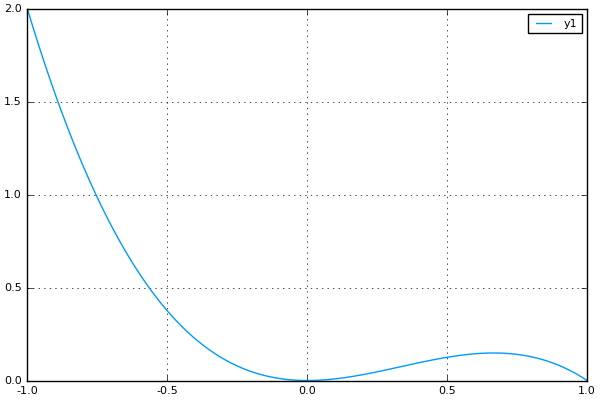

/Users/dpsanders/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:
using Plots
plot(f, -1, 1)

Note, however, that the result is an **over-estimate**, since the true range of the function is $[0, 2]$, not $[-1, 2]$. This will, in general, be the case with interval arithmetic, due to the **dependency problem** (the fact that `x` is repeated twice in the expression, and it does not know that the `x`s are the same).

**Exercise:** How can we reduce this over-estimate?

Note that

In [85]:
a = Interval(0.1)

[0.1, 0.100001]

In [86]:
showall(a)

Interval(0.1, 0.1)

does *not* round $0.1$, so that this interval **does not contain the true real number $0.1$**

Instead, we use the `@interval` macro:

In [89]:
b = @interval(0.1)

[0.0999999, 0.100001]

In [90]:
showall(b)

Interval(0.09999999999999999, 0.1)

We can also do e.g.

In [92]:
@interval 0.1 * sin(0.2π)

[0.0587785, 0.0587786]

Recall that macros like `@interval` have access to the expression that they are passed. We can find out what they do:

In [93]:
macroexpand(:(@interval 0.1 * sin(0.2π)))

:((ValidatedNumerics.convert)(Interval{parameters.precision_type},0.1) * sin((ValidatedNumerics.convert)(Interval{parameters.precision_type},0.2) * (ValidatedNumerics.convert)(Interval{parameters.precision_type},π)))

Basically it wraps all literals like `0.1` into `convert(Interval{T}, 0.1)`, where `T` is the current global interval type (that may be changed using e.g. `setprecision(Interval, 100)`).

In [95]:
convert(Interval{Float64}, 0.1)

[0.0999999, 0.100001]